In [1]:
import pandas as pd
import os
from typing import Dict
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
start = 1999
end = 2015

In [3]:
def get_filepaths(dir_path: str) -> Dict:
    filepaths = dict()
    for fn in os.listdir(dir_path):
        if fn.startswith("DIQ"):
            filepaths['diabetes'] = os.path.join(dir_path, fn)
        elif fn.startswith("DPQ"):
            filepaths['depression'] = os.path.join(dir_path, fn)
        elif fn.startswith("ALQ"):
            filepaths['alcohol'] = os.path.join(dir_path, fn)
        elif fn.startswith("DEMO"):
            filepaths['demographics'] = os.path.join(dir_path, fn) 
        elif fn.startswith("MCQ"):
            filepaths['chd'] = os.path.join(dir_path, fn) 
            
    return filepaths

def read_alcohol_use_file(fp: str) -> pd.DataFrame:
    df = pd.read_sas(fp)
    
    desired_col = None
    for col in df.columns:
        if col.startswith('ALQ') or col.startswith("ALD"):
            code = col[3:]
            if code.endswith('Q') or code.endswith('U'):
                continue
            code = int(code)
            if abs(code - 150) <= 2:
                desired_col = col
                break
    df.rename(columns={desired_col: "ALQ150"}, inplace=True)
    df = df[['SEQN', "ALQ150"]]
    df.dropna(how='any', axis=0, inplace=True)
    
    return df

In [4]:
demo_vars_codes = {
    'RIDAGEYR': 'Age', 
    'RIAGENDR': 'Gender', 
    'RIDRETH1': 'Race/Ethnicity', 
    'DMDEDUC3': 'Education Level - Children/Youth 6-19', 
    'DMDEDUC2': 'Education Level - Adults 20+', 
    'DMDHHSIZ': 'Total number of people in the Household', 
    'INDFMPIR': 'Poverty Income Ratio'
}

age_resp_desc = {
    1: 'Male', 
    2: 'Female', 
    100: 'Unknown'
}

race_resp_desc = {
    1: 'Mexican American', 
    2: 'Other Hispanic', 
    3: 'Non-Hispanic White', 
    4: 'Non-Hispanic Black', 
    5: 'Other Race - Including Multi-Racial'
}

youth_edu_desc = {
    0: 'Never Attended / Kindergarten Only', 
    1: '1st Grade', 
    2: '2nd Grade', 
    3: '3rd Grade', 
    4: '4th Grade', 
    5: '5th Grade', 
    6: '6th Grade', 
    7: '7th Grade', 
    8: '8th Grade', 
    9: '9th Grade', 
    10: '10th Grade', 
    11: '11th Grade', 
    12: '12th Grade, No Diploma', 
    13: 'High School Graduate', 
    14: 'GED or Equivalent', 
    15: 'More than high school', 
    55: 'Less Than 5th Grade-3', 
    66: 'Less Than 9th Grade-53', 
    77: 'Refused', 
    99: "Don't know", 
    100: 'Unknown'
}

adult_edu_desc = {
    1: ' < 9th Grade', 
    2: '9-12th Grade (no diploma)', 
    3: 'High School Grad/GED or Equivalent', 
    4: 'College or AA degree', 
    5: 'College Graduate or above', 
    7: 'Refused', 
    9: "Don't Know", 
    100: 'Unknown'
}

In [5]:
merged_list = []
total_mort = 0
for year in range(start, end, 2):
    fp = f"data/{year}-{year+1}/mort.csv"
    mort = pd.read_csv(fp)[['seqn', 'mortstat']]
    mort.rename(columns={'seqn': 'SEQN'}, inplace=True)
    mort.dropna(how='any', axis=0, inplace=True)
#     print(mort.shape)
    mort = mort[mort.mortstat == 1]
    total_mort += mort.shape[0]
#     print(mort.shape)
    
    
    dir_path = f"data/{year}-{year+1}/questionnaire/"
    fp_s = get_filepaths(dir_path)
    
    fp_demo = get_filepaths(f"data/{year}-{year+1}/demographics/")
    
    chd = pd.read_sas(fp_s['chd'])[['SEQN', 'MCQ160C']]
    chd.dropna(how='any', axis=0, inplace=True)
    dbts = pd.read_sas(fp_s['diabetes'])[['SEQN', 'DIQ010']]
    dbts.dropna(how='any', axis=0, inplace=True)
    age = pd.read_sas(fp_demo['demographics'])[['SEQN', *list(demo_vars_codes.keys())]]
    age.fillna(100, inplace=True)
    alc = read_alcohol_use_file(fp_s['alcohol'])
    
    temp_1 = pd.merge(mort, chd, on='SEQN')
    temp_2 = pd.merge(temp_1, dbts, on='SEQN')
    temp_3 = pd.merge(temp_2, age, on='SEQN')
    merged = pd.merge(temp_3, alc, on='SEQN')
    merged_list.append(merged)

/home/bisag/miniconda3/envs/health_care/lib/python3.7/site-packages/pandas/io/sas/sas_xport.py:475: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [6]:
total_mort

6314

In [7]:
df = pd.concat(merged_list)
df.shape

(4108, 12)

In [8]:
for col in df.columns[1:]:
    print(df[col].value_counts())

1.0    4108
Name: mortstat, dtype: int64
2.0    3510
1.0     534
9.0      64
Name: MCQ160C, dtype: int64
2.0    3115
1.0     894
3.0      96
9.0       3
Name: DIQ010, dtype: int64
80.0    449
85.0    370
75.0    141
81.0    135
78.0    126
       ... 
30.0      8
35.0      7
24.0      7
29.0      4
32.0      4
Name: RIDAGEYR, Length: 66, dtype: int64
1.0    2586
2.0    1522
Name: RIAGENDR, dtype: int64
3.0    2468
4.0     769
1.0     630
2.0     147
5.0      94
Name: RIDRETH1, dtype: int64
100.0    4108
Name: DMDEDUC3, dtype: int64
3.0    989
4.0    900
1.0    894
2.0    811
5.0    499
9.0     12
7.0      3
Name: DMDEDUC2, dtype: int64
2.0    1735
1.0    1148
3.0     483
4.0     314
5.0     192
7.0     138
6.0      98
Name: DMDHHSIZ, dtype: int64
5.00      409
100.00    394
1.20       32
1.07       27
1.08       26
         ... 
4.82        1
4.08        1
4.34        1
4.91        1
4.11        1
Name: INDFMPIR, Length: 465, dtype: int64
2.0    3133
1.0     966
9.0       8
7.0       1

In [9]:
# fig = px.histogram(df, x="RIDAGEYR", title="Histogram of People Who had Died (Age)")
# fig.show()

In [10]:
df['age_category'] = df.RIDAGEYR.astype(int) // 10

In [11]:
age_group_info = {
    1: '10-19', 
    2: '20-29', 
    3: '30-39', 
    4: '40-49', 
    5: '50-59', 
    6: '60-69', 
    7: '70-79', 
    8: '80-89', 
    9: 'all'
}

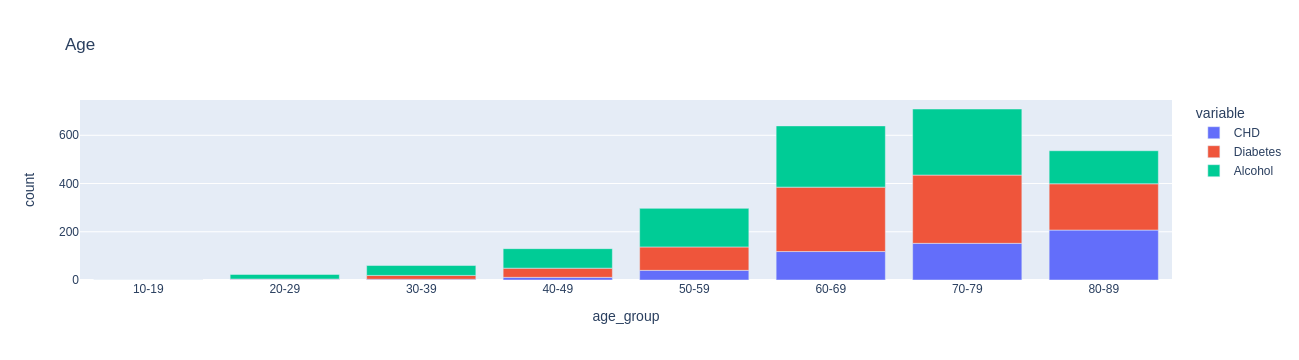

In [12]:
col = 'RIDAGEYR'

temp = {'CHD': [], 'Diabetes': [], 'Alcohol': [], 'age_group': []}
for i in range(1, 9):
    values = df[df.age_category == i] if i != 9 else df
    total = values.shape[0]
    
    temp['age_group'].append(age_group_info[i])
    temp['CHD'].append(values[values['MCQ160C'] == 1].shape[0])
    temp['Diabetes'].append(values[values['DIQ010'] == 1].shape[0])
    temp['Alcohol'].append(values[values['ALQ150'] == 1].shape[0])
    
temp_df = pd.DataFrame(temp)
temp_df.to_csv('Pictures/mort/age_bar.csv')
fig = px.bar(temp_df, x="age_group", y=list(temp.keys()), title='Age')
fig.update_layout(yaxis_title='count')
fig.write_image('Pictures/mort/age_bar.png')
fig.show()

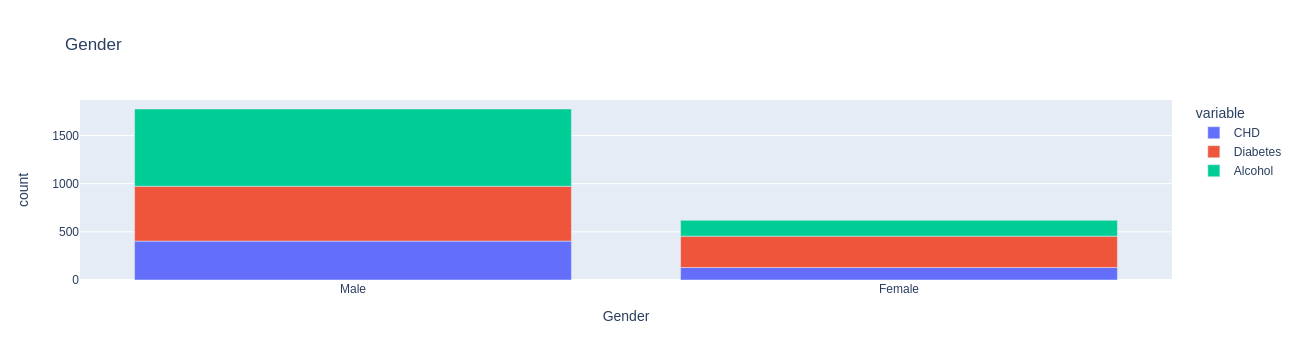

In [13]:
col = 'RIAGENDR'

temp = {'CHD': [], 'Diabetes': [], 'Alcohol': [], 'Gender': []}

gender_dict = {
    1: 'Male', 
    2: 'Female'
}

for i in range(1, 3):
    values = df[df[col] == i]
    
    temp['Gender'].append(gender_dict[i])
    temp['CHD'].append(values[values['MCQ160C'] == 1].shape[0])
    temp['Diabetes'].append(values[values['DIQ010'] == 1].shape[0])
    temp['Alcohol'].append(values[values['ALQ150'] == 1].shape[0])
    
temp_df = pd.DataFrame(temp)
temp_df.to_csv('Pictures/mort/gender_bar.csv')
fig = px.bar(temp_df, x="Gender", y=list(temp.keys()), title='Gender')
fig.update_layout(yaxis_title='count')
fig.write_image('Pictures/mort/gender_bar.png')
fig.show()

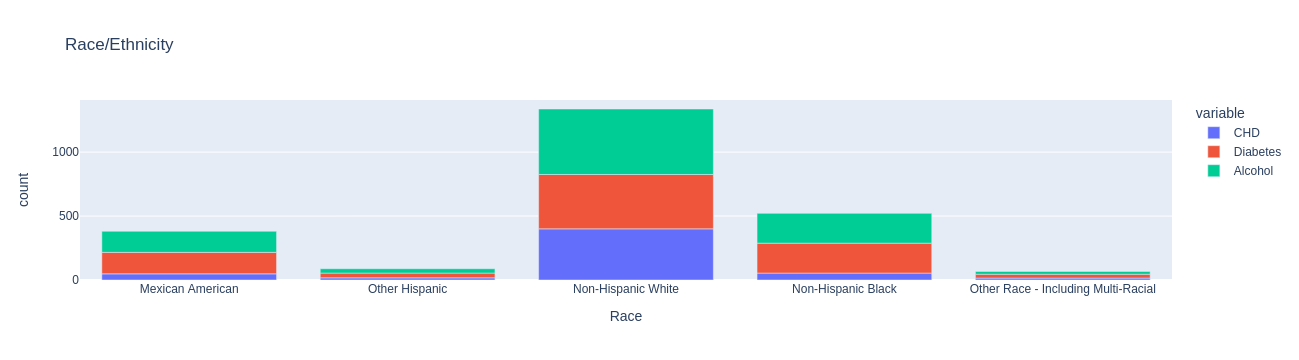

In [14]:
col = 'RIDRETH1'

temp = {'CHD': [], 'Diabetes': [], 'Alcohol': [], 'Race': []}


for i in range(1, 6):
    values = df[df[col] == i]
    
    temp['Race'].append(race_resp_desc[i])
    temp['CHD'].append(values[values['MCQ160C'] == 1].shape[0])
    temp['Diabetes'].append(values[values['DIQ010'] == 1].shape[0])
    temp['Alcohol'].append(values[values['ALQ150'] == 1].shape[0])
    
temp_df = pd.DataFrame(temp)
temp_df.to_csv('Pictures/mort/race_bar.csv')
fig = px.bar(temp_df, x="Race", y=list(temp.keys()), title='Race/Ethnicity')
fig.update_layout(yaxis_title='count')
fig.write_image('Pictures/mort/race_bar.png')
fig.show()

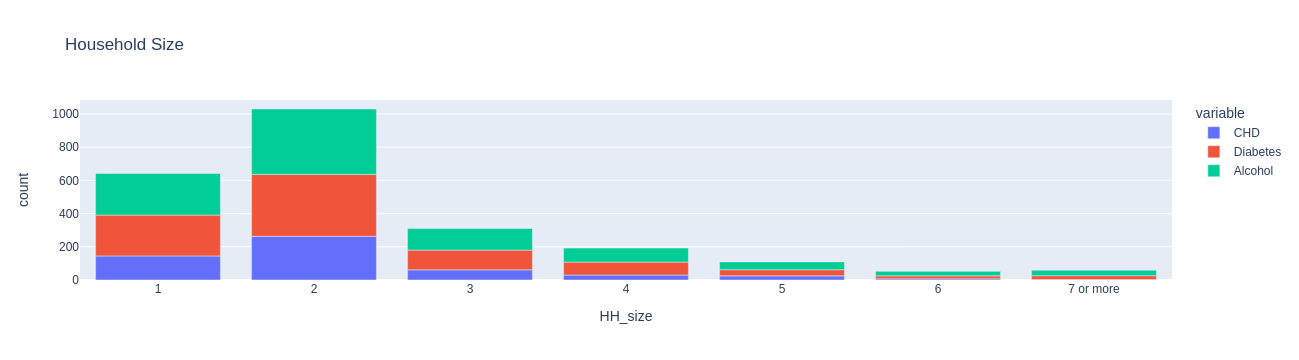

In [15]:
col = 'DMDHHSIZ'

temp = {'CHD': [], 'Diabetes': [], 'Alcohol': [], 'HH_size': []}

for i in range(1, 8):
    values = df[df[col] == i]
    
    temp['HH_size'].append(str(i)) if i != 7 else temp['HH_size'].append('7 or more')
    temp['CHD'].append(values[values['MCQ160C'] == 1].shape[0])
    temp['Diabetes'].append(values[values['DIQ010'] == 1].shape[0])
    temp['Alcohol'].append(values[values['ALQ150'] == 1].shape[0])
    
temp_df = pd.DataFrame(temp)
temp_df.to_csv('Pictures/mort/hh_size_bar.csv')
fig = px.bar(temp_df, x="HH_size", y=list(temp.keys()), title='Household Size')
fig.update_layout(yaxis_title='count')
fig.write_image('Pictures/mort/hh_size_bar.png')
fig.show()

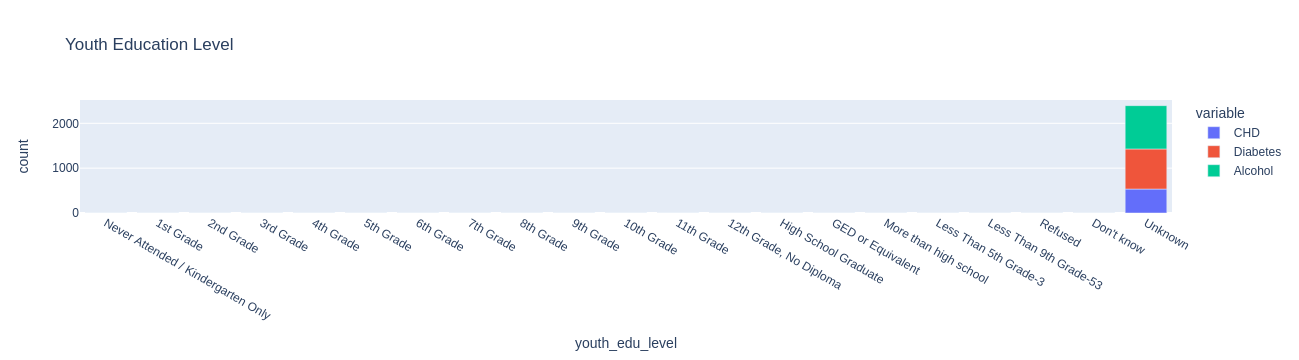

In [16]:
col = 'DMDEDUC3'

temp = {'CHD': [], 'Diabetes': [], 'Alcohol': [], 'youth_edu_level': []}

for i in youth_edu_desc.keys():
    values = df[df[col] == i]
    
    temp['youth_edu_level'].append(youth_edu_desc[i])
    temp['CHD'].append(values[values['MCQ160C'] == 1].shape[0])
    temp['Diabetes'].append(values[values['DIQ010'] == 1].shape[0])
    temp['Alcohol'].append(values[values['ALQ150'] == 1].shape[0])
    
temp_df = pd.DataFrame(temp)
temp_df.to_csv('Pictures/mort/youth_edu_bar.csv')
fig = px.bar(temp_df, x="youth_edu_level", y=list(temp.keys()), title='Youth Education Level')
fig.update_layout(yaxis_title='count')
fig.write_image('Pictures/mort/youth_edu_bar.png')
fig.show()

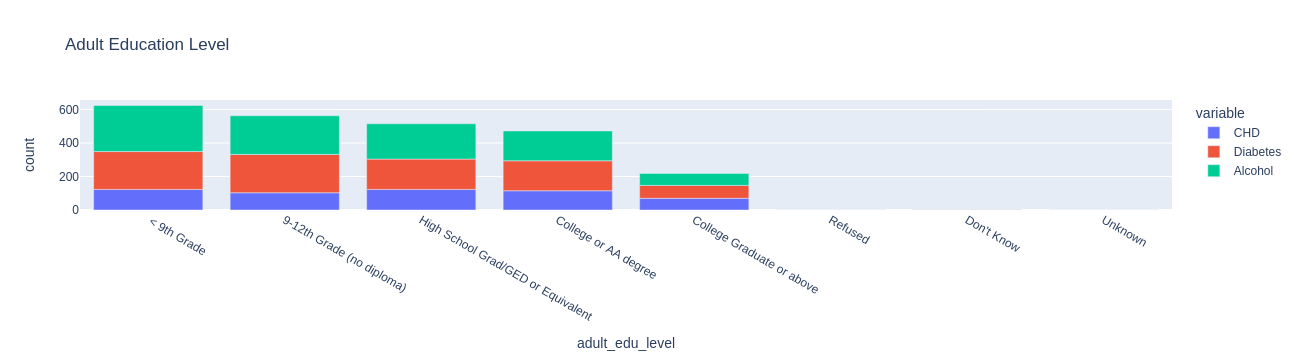

In [17]:
col = 'DMDEDUC2'

temp = {'CHD': [], 'Diabetes': [], 'Alcohol': [], 'adult_edu_level': []}

for i in adult_edu_desc.keys():
    values = df[df[col] == i]
    
    temp['adult_edu_level'].append(adult_edu_desc[i])
    temp['CHD'].append(values[values['MCQ160C'] == 1].shape[0])
    temp['Diabetes'].append(values[values['DIQ010'] == 1].shape[0])
    temp['Alcohol'].append(values[values['ALQ150'] == 1].shape[0])
    
temp_df = pd.DataFrame(temp)
temp_df.to_csv('Pictures/mort/adult_edu_bar.csv')
fig = px.bar(temp_df, x="adult_edu_level", y=list(temp.keys()), title='Adult Education Level')
fig.update_layout(yaxis_title='count')
fig.write_image('Pictures/mort/adult_edu_bar.png')
fig.show()

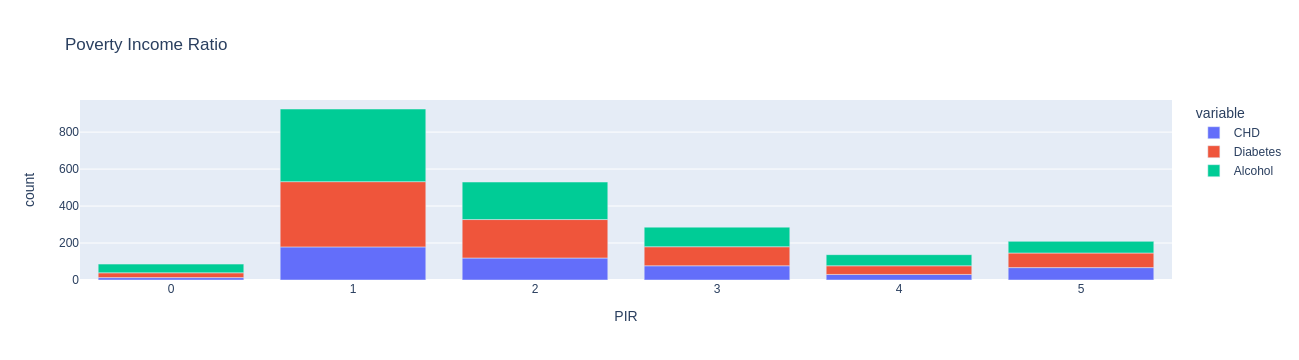

In [18]:
col = 'INDFMPIR'
temp = {'CHD': [], 'Diabetes': [], 'Alcohol': [], 'PIR': []}

df['INDFMPIR_rounded'] = df[col].round(decimals = 0)
col = 'INDFMPIR_rounded'

for i in range(0, 6):
    values = df[df[col] == i]
    
    temp['PIR'].append(i)
    temp['CHD'].append(values[values['MCQ160C'] == 1].shape[0])
    temp['Diabetes'].append(values[values['DIQ010'] == 1].shape[0])
    temp['Alcohol'].append(values[values['ALQ150'] == 1].shape[0])
    
temp_df = pd.DataFrame(temp)
temp_df.to_csv('Pictures/mort/pir_bar.csv')
fig = px.bar(temp_df, x="PIR", y=list(temp.keys()), title='Poverty Income Ratio')
fig.update_layout(yaxis_title='count')
fig.write_image('Pictures/mort/pir_bar.png')
fig.show()

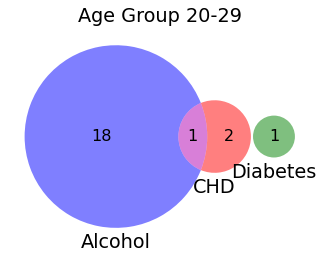

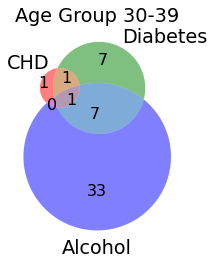

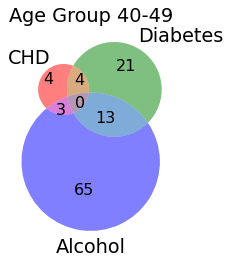

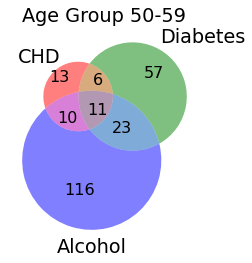

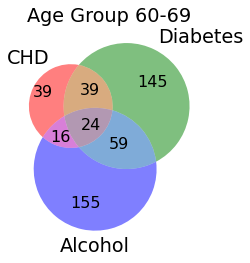

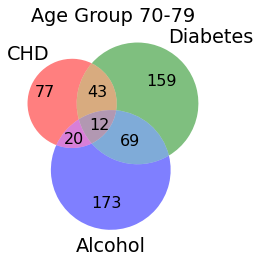

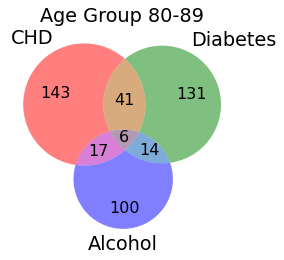

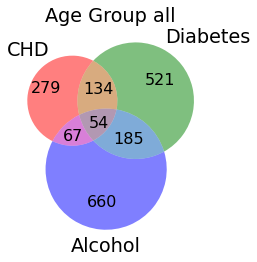

In [19]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_venn import venn3

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

set_labels = ('CHD', 'Diabetes', 'Alcohol')
labels = ['chd', 'dbts', 'chd_dbts', 'alc', 'chd_alc', 'dbts_alc', 'chd_dbts_alc', 'age_category']
data = []
for age_group_id in range(1, 10):
    subsets = [0]*7
    
    sel_df = df[df['age_category'] == age_group_id] if age_group_id != 9 else df
    
    subsets[0] = sel_df[(sel_df['MCQ160C'] == 1.0) & (sel_df['DIQ010'] != 1.0) & (sel_df['ALQ150'] != 1.0)].shape[0]
    subsets[1] = sel_df[(sel_df['MCQ160C'] != 1.0) & (sel_df['DIQ010'] == 1.0) & (sel_df['ALQ150'] != 1.0)].shape[0]
    subsets[2] = sel_df[(sel_df['MCQ160C'] == 1.0) & (sel_df['DIQ010'] == 1.0) & (sel_df['ALQ150'] != 1.0)].shape[0]
    subsets[3] = sel_df[(sel_df['MCQ160C'] != 1.0) & (sel_df['DIQ010'] != 1.0) & (sel_df['ALQ150'] == 1.0)].shape[0]
    subsets[4] = sel_df[(sel_df['MCQ160C'] == 1.0) & (sel_df['DIQ010'] != 1.0) & (sel_df['ALQ150'] == 1.0)].shape[0]
    subsets[5] = sel_df[(sel_df['MCQ160C'] != 1.0) & (sel_df['DIQ010'] == 1.0) & (sel_df['ALQ150'] == 1.0)].shape[0]
    subsets[6] = sel_df[(sel_df['MCQ160C'] == 1.0) & (sel_df['DIQ010'] == 1.0) & (sel_df['ALQ150'] == 1.0)].shape[0]
#     subsets[0] = sel_df[(sel_df['MCQ160C'] == 1.0)].shape[0]
#     subsets[1] = sel_df[(sel_df['DIQ010'] == 1.0)].shape[0]
#     subsets[2] = sel_df[(sel_df['MCQ160C'] == 1.0) & (sel_df['DIQ010'] == 1.0)].shape[0]
#     subsets[3] = sel_df[(sel_df['ALQ100'] == 1.0)].shape[0]
#     subsets[4] = sel_df[(sel_df['MCQ160C'] == 1.0) & (sel_df['ALQ100'] == 1.0)].shape[0]
#     subsets[5] = sel_df[(sel_df['DIQ010'] == 1.0) & (sel_df['ALQ100'] == 1.0)].shape[0]
#     subsets[6] = sel_df[(sel_df['MCQ160C'] == 1.0) & (sel_df['DIQ010'] == 1.0) & (sel_df['ALQ100'] == 1.0)].shape[0]
    
    
    data.append([*subsets, age_group_info[age_group_id]])
    
    if not all(v == 0 for v in subsets):
        venn3(subsets = subsets, set_labels = set_labels, alpha = 0.5)
        plt.title(f'Age Group {age_group_info[age_group_id]}')
        matplotlib.pyplot.savefig(f'Pictures/mort/age_group_{age_group_id}_ven.png', facecolor='white')
        plt.show()
temp_df = pd.DataFrame(data, columns=labels)
temp_df.to_csv(f'Pictures/mort/age_group_ven.csv')

In [20]:
for age_group_id in range(1, 10):
    sel_df = df[df['age_category'] == age_group_id] if age_group_id != 9 else df
    temp = sel_df[(sel_df['MCQ160C'] != 1.0) & (sel_df['DIQ010'] != 1.0) & (sel_df['ALQ150'] != 1.0)].shape[0]
    print(f"Age group {age_group_info[age_group_id]} (U - (A U B U C)): {temp}, (A U B U C): {sel_df.shape[0] - temp}")

Age group 10-19 (U - (A U B U C)): 0, (A U B U C): 0
Age group 20-29 (U - (A U B U C)): 91, (A U B U C): 22
Age group 30-39 (U - (A U B U C)): 71, (A U B U C): 50
Age group 40-49 (U - (A U B U C)): 164, (A U B U C): 110
Age group 50-59 (U - (A U B U C)): 171, (A U B U C): 236
Age group 60-69 (U - (A U B U C)): 352, (A U B U C): 477
Age group 70-79 (U - (A U B U C)): 582, (A U B U C): 553
Age group 80-89 (U - (A U B U C)): 777, (A U B U C): 452
Age group all (U - (A U B U C)): 2208, (A U B U C): 1900


In [42]:
df = pd.read_csv("EXPACT_NHANES_dataset.csv")

In [43]:
df.columns

Index(['Questionnaire_100Cigarettes', 'Dietary_Caffeine',
       'Questionnaire_SelfReportedWeight10YrAgo',
       'Questionnaire_AntacidsLaxativesAntiDiarrheal',
       'Laboratory_WhiteBloodCellCount', 'Laboratory_Cotinine', 'Dietary_Pike',
       'Laboratory_Sodium', 'Examination_BPDiastolic3',
       'Questionnaire_NoInsuranceTime',
       ...
       'Dietary_VitaminB1', 'Questionnaire_JobMonths',
       'Questionnaire_SelfReportedHeight', 'mortstat', 'permth_int',
       '1_year_label', '2_year_label', '3_year_label', '4_year_label',
       '5_year_label'],
      dtype='object', length=216)

In [44]:
df = df[df.columns[:-6]]

In [45]:
categorical_columns = []
for col_name in df.columns:
    nb_unique = df[col_name].nunique()
    if nb_unique < 10 and col_name not in ['mortstat']:
        if nb_unique == 2:
            df[col_name] -= 1
        else:
            print(nb_unique, col_name, df[col_name].unique())
            categorical_columns.append(col_name)

# print(categorical_columns)
df = pd.get_dummies(df, columns=categorical_columns)

3 Questionnaire_HealthCareLocation [1. 3. 2.]
5 Demographics_RaceEthnicity [3. 4. 1. 2. 5.]
3 Questionnaire_HealthComparedToYearAgo [2. 3. 1.]
3 Laboratory_HepAAntibody [2. 1. 3.]
5 Examination_BPCuffSize [3. 4. 2. 5. 1.]
5 Demographics_Education [5. 2. 3. 4. 1.]
3 Questionnaire_ExamSession [0. 2. 1.]
3 Dietary_DSAntacid [2. 0. 1.]
3 Questionnaire_HepB3DoseSeries [3. 1. 2.]
6 Questionnaire_JobDescription [1. 4. 5. 3. 2. 6.]
3 Questionnaire_DoctorDiabetes [2. 1. 3.]
3 Questionnaire_ConsiderWeight [3. 1. 2.]
6 Dietary_DSMatchingCode [1. 4. 2. 5. 3. 6.]
8 Demographics_ReleaseCycle [1. 2. 3. 4. 5. 6. 7. 8.]
7 Demographics_HouseholdSize [1. 3. 4. 2. 6. 7. 5.]
5 Questionnaire_GeneralHealth [2. 1. 3. 4. 5.]
6 Demographics_MaritalStatus [1. 4. 5. 3. 6. 2.]
4 Questionnaire_LastCholesterolCheck [1. 2. 3. 4.]
3 Questionnaire_HomeOwnBoughtRent [2. 1. 3.]


In [46]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)

    return list(col_corr)

redundant_columns = correlation(df, 0.5)
print(redundant_columns)
df = df.drop(redundant_columns, axis=1)

['Laboratory_TotalProtein', 'Laboratory_Chloride', 'Dietary_VitaminB6', 'Questionnaire_ExamSession_1.0', 'Questionnaire_SelfReportedHeight', 'Questionnaire_ConsiderWeight_3.0', 'Dietary_Docosapentaenoic', 'Dietary_Carbohydrate', 'Questionnaire_LastCholesterolCheck_3.0', 'Examination_Weight', 'Dietary_Iron', 'Dietary_Decanoic', 'Laboratory_MeanCellHemoglobin', 'Dietary_Cholesterol', 'Questionnaire_JobDescription_5.0', 'Laboratory_HepAAntibody_2.0', 'Questionnaire_DoctorDiabetes_2.0', 'Laboratory_Monocyte', 'Demographics_ReleaseCycle_1.0', 'Demographics_Age', 'Examination_UpperArmLength', 'Dietary_DSAntacid_0.0', 'Dietary_Eicosapentaenoic', 'Examination_Height', 'Dietary_Octadecatetraenoic', 'Questionnaire_HepB3DoseSeries_3.0', 'Examination_BPSystolic2', 'Questionnaire_LastCholesterolCheck_2.0', 'Examination_BPSystolic1', 'Dietary_VitaminB2', 'Laboratory_Osmolality', 'Dietary_Calcium', 'Examination_WaistCircum', 'Laboratory_Creatinine', 'Laboratory_Lymphocyte', 'Demographics_MaritalStatu

In [47]:
df.isnull().sum()

Questionnaire_100Cigarettes                     0
Dietary_Caffeine                                0
Questionnaire_SelfReportedWeight10YrAgo         0
Questionnaire_AntacidsLaxativesAntiDiarrheal    0
Laboratory_WhiteBloodCellCount                  0
                                               ..
Demographics_MaritalStatus_6.0                  0
Questionnaire_LastCholesterolCheck_1.0          0
Questionnaire_LastCholesterolCheck_4.0          0
Questionnaire_HomeOwnBoughtRent_1.0             0
Questionnaire_HomeOwnBoughtRent_3.0             0
Length: 194, dtype: int64

In [48]:
df.shape

(47279, 194)

In [49]:
X = df.loc[:, df.columns != 'mortstat']
y = df['mortstat']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [51]:
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
X_test_resampled = pd.DataFrame(X_test_resampled, columns=X.columns)

In [52]:
print(y_train_resampled.value_counts())
print(y_test_resampled.value_counts())

0.0    32846
1.0    32846
Name: mortstat, dtype: int64
0.0    8119
1.0    8119
Name: mortstat, dtype: int64


In [53]:
model = XGBClassifier(use_label_encoder=False, eval_metric='error')
model.fit(X_train_resampled, y_train_resampled)
y_pred_resampled = model.predict(X_test_resampled)

accuracy = accuracy_score(y_test_resampled, y_pred_resampled)
print(f"Accuracy: {accuracy}")
conf = pd.DataFrame(confusion_matrix(y_test_resampled, y_pred_resampled), index=['GT_0', 'GT_1'], columns=['PRED_0', 'PRED_1'])
conf

Accuracy: 0.9434659440817835


PRED_0  PRED_1
GT_0    7856     263
GT_1     655    7464

In [54]:
keys = list(model.get_booster().feature_names)
values = list(model.feature_importances_)

feature_importance_matrix = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
top_features = feature_importance_matrix[:30]
imp_ftrs_plot = top_features.sort_values(by='score').plot(kind='barh', figsize=(10, 8))
fig = imp_ftrs_plot.get_figure()
fig.savefig('Pictures/mort/top_features.png', facecolor='white', bbox_inches="tight")

In [55]:
feature_list = top_features.index.tolist()
feature_list.append('mortstat')

In [56]:
df_filtered = df.filter(feature_list)

In [57]:
_, ax = plt.subplots(figsize=(10,10))

sns_plot = sns.heatmap(df_filtered.corr(), ax=ax, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True)
ax.set_title('Correlation Coefficient Matrix')
fig = sns_plot.get_figure()
fig.savefig('Pictures/mort/feature_corr.png', facecolor='white', bbox_inches = "tight")

In [58]:
X_filtered = df_filtered.loc[:, df_filtered.columns != 'mortstat']
y = df_filtered['mortstat']

In [59]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
X_test_resampled = pd.DataFrame(X_test_resampled, columns=X.columns)

In [61]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=100, solver='lbfgs', class_weight='balanced', random_state=0)
lr_model.fit(X_train_resampled, y_train_resampled)

y_pred = lr_model.predict(X_test_resampled)

print(f'Accuracy Score: {lr_model.score(X_test_resampled, y_test_resampled)}')

print(classification_report(y_test_resampled, y_pred))
confusion_matrix(y_test_resampled, y_pred)

Accuracy Score: 0.8183273802192388
              precision    recall  f1-score   support

         0.0       0.83      0.80      0.82      8119
         1.0       0.81      0.83      0.82      8119

    accuracy                           0.82     16238
   macro avg       0.82      0.82      0.82     16238
weighted avg       0.82      0.82      0.82     16238



array([[6521, 1598],
       [1352, 6767]])

In [63]:
lr_model.summary()

AttributeError: 'LogisticRegression' object has no attribute 'summary'